In [9]:
import os
import shutil
import glob
import cv2
import numpy as np
from scipy.io import loadmat

print("Environment Ready")


Environment Ready


In [10]:
SRC = "/kaggle/input/shanghaitech/ShanghaiTech"
DST = "/kaggle/working/shanghaitech"

if not os.path.exists(DST):
    shutil.copytree(SRC, DST)

print("Dataset copied to:", DST)
print(os.listdir(DST))


Dataset copied to: /kaggle/working/shanghaitech
['part_A', 'part_B']


In [11]:
DATA_ROOT = "/kaggle/working/shanghaitech"

PART_A_TRAIN = f"{DATA_ROOT}/part_A/train_data"
PART_A_TEST  = f"{DATA_ROOT}/part_A/test_data"

print("Train data:", os.listdir(PART_A_TRAIN))
print("Test data:", os.listdir(PART_A_TEST))


Train data: ['images', 'ground-truth']
Test data: ['images', 'ground-truth']


In [12]:
def get_counts(folder):
    img_dir = os.path.join(folder, "images")
    gt_dir = os.path.join(folder, "ground-truth")

    img_paths = sorted(glob.glob(os.path.join(img_dir, "*.jpg")))
    counts = []

    for img_path in img_paths:
        base = os.path.basename(img_path).replace(".jpg", "")
        mat_path = os.path.join(gt_dir, f"GT_{base}.mat")

        mat = loadmat(mat_path)

        
        points = mat["image_info"][0][0][0][0][0]

        counts.append(len(points))

    return img_paths, np.array(counts)


In [13]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from skimage.feature import hog

def extract_features(img_paths, size=128):
    """
    Extract combined visual features for each image:
    - Resized grayscale pixels
    - HOG features
    - LBP features
    - Edge density
    - Brightness stats
    - ORB keypoint count
    """
    features = []

    # LBP params
    radius = 2
    n_points = 8 * radius

    for p in img_paths:
        img = cv2.imread(p)
        if img is None:
            print("Could not read:", p)
            continue
        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_small = cv2.resize(gray, (size, size))

       
        #Flattened pixel intensities
        raw_pix = gray_small.flatten()

        # HOG descriptor 
        hog_feat = hog(
            gray_small,
            orientations=8,
            pixels_per_cell=(16, 16),
            cells_per_block=(1, 1),
            visualize=False,
            channel_axis=None
        )
        # LBP texture histogram
        lbp = local_binary_pattern(gray_small, n_points, radius, method="uniform")
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=int(lbp.max() + 1), density=True)

        # Edge Density (Canny)
        edges = cv2.Canny(gray_small, 100, 200)
        edge_density = np.sum(edges > 0) / edges.size  # 0–1

        # Brightness stats
        mean_intensity = np.mean(gray_small)
        var_intensity  = np.var(gray_small)

        # ORB keypoints count

        orb = cv2.ORB_create()
        keypoints = orb.detect(gray_small, None)
        kpt_count = len(keypoints)


        # Combine all features
        feat_vector = np.concatenate([
            raw_pix,           # pixel values
            hog_feat,          # structure
            lbp_hist,          # texture
            [edge_density],    # edges
            [mean_intensity, var_intensity],
            [kpt_count],       # keypoints
        ])

        features.append(feat_vector)

    return np.array(features)


In [14]:
from sklearn.model_selection import train_test_split


# Load image paths & GT counts
train_img_paths, train_counts = get_counts(PART_A_TRAIN)
test_img_paths,  test_counts  = get_counts(PART_A_TEST)

print("Train images:", len(train_img_paths), " Test images:", len(test_img_paths))


# Extract features
print("Extracting training features...")
train_features = extract_features(train_img_paths)

print("Extracting test features...")
test_features  = extract_features(test_img_paths)


# 3. Convert to X, y
train_X = train_features
train_y = train_counts

test_X  = test_features
test_y  = test_counts

print("Shapes:")
print("train_X:", train_X.shape)
print("train_y:", train_y.shape)
print("test_X:", test_X.shape)
print("test_y:", test_y.shape)


Train images: 300  Test images: 182
Extracting training features...
Extracting test features...
Shapes:
train_X: (300, 16918)
train_y: (300,)
test_X: (182, 16918)
test_y: (182,)


In [15]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

rf.fit(train_X, train_y)
print("Random Forest training completed!")


Random Forest training completed!


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


# 1. Predict on train & test
pred_train = rf.predict(train_X)
pred_test  = rf.predict(test_X)


# Metrics
mae_train = mean_absolute_error(train_y, pred_train)
rmse_train = np.sqrt(mean_squared_error(train_y, pred_train))
r2_train = r2_score(train_y, pred_train)

mae_test = mean_absolute_error(test_y, pred_test)
rmse_test = np.sqrt(mean_squared_error(test_y, pred_test))
r2_test = r2_score(test_y, pred_test)


# Print summary

print("========== Random Forest Evaluation ==========")
print(f"Train MAE :  {mae_train:.3f}")
print(f"Train RMSE: {rmse_train:.3f}")
print(f"Train R²  : {r2_train:.3f}")
print("----------------------------------------------")
print(f"Test  MAE : {mae_test:.3f}")
print(f"Test  RMSE: {rmse_test:.3f}")
print(f"Test R²   : {r2_test:.3f}")
print("==============================================")


# 4. Show some predictions

for i in range(5):
    print(f"Image: {os.path.basename(test_img_paths[i])} | GT: {test_y[i]} | Pred: {pred_test[i]:.1f}")


========== Random Forest Evaluation ==========
Train MAE :  107.853
Train RMSE: 155.522
Train R²  : 0.905
----------------------------------------------
Test  MAE : 237.064
Test  RMSE: 296.678
Test R²   : 0.296
Image: IMG_1.jpg | GT: 172 | Pred: 575.9
Image: IMG_10.jpg | GT: 502 | Pred: 540.8
Image: IMG_100.jpg | GT: 389 | Pred: 463.0
Image: IMG_101.jpg | GT: 211 | Pred: 500.0
Image: IMG_102.jpg | GT: 223 | Pred: 549.4


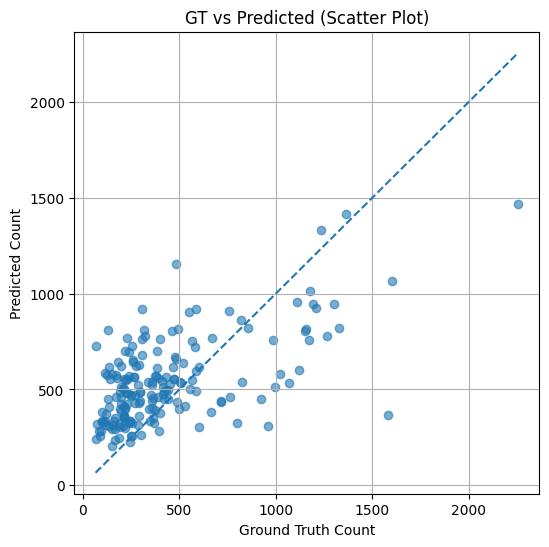

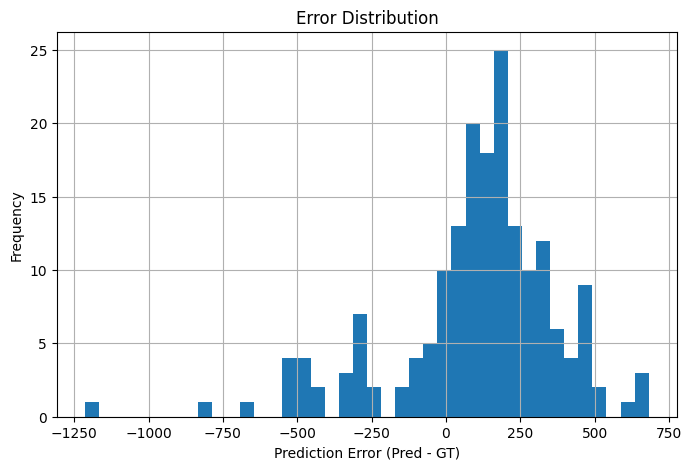

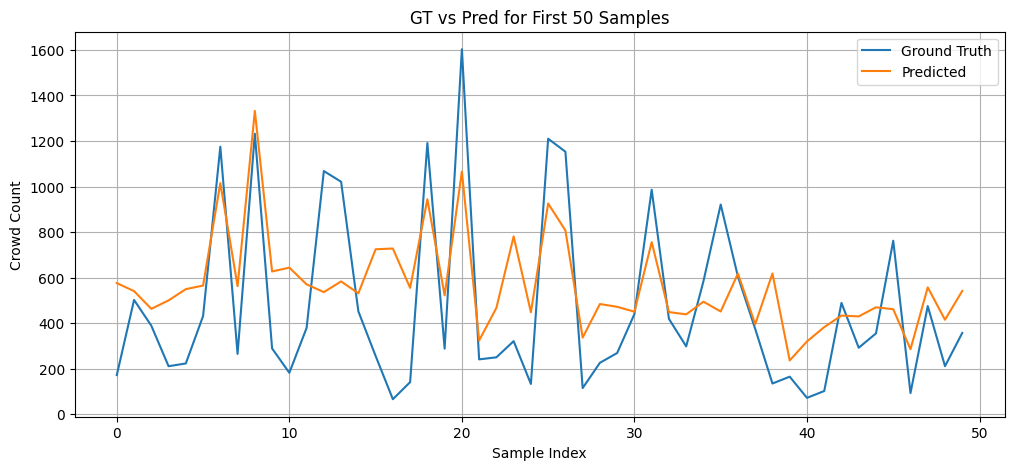

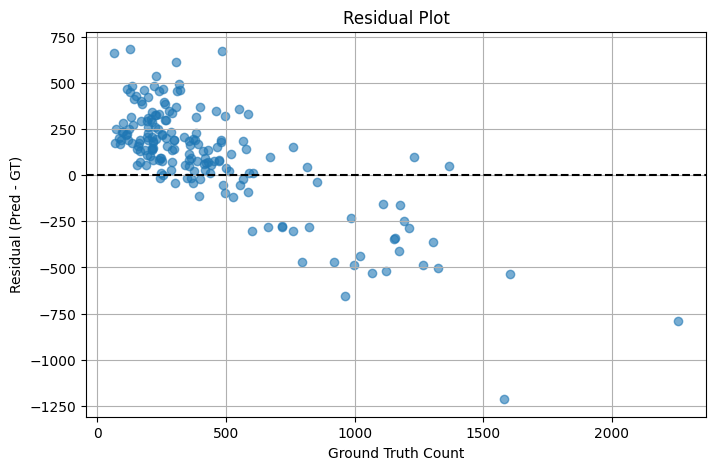

In [17]:
import matplotlib.pyplot as plt
import numpy as np


# Scatter plot: Ground Truth vs Predicted Count
plt.figure(figsize=(6,6))
plt.scatter(test_y, pred_test, alpha=0.6)
plt.plot([test_y.min(), test_y.max()], 
         [test_y.min(), test_y.max()], 
         linestyle='--')
plt.xlabel("Ground Truth Count")
plt.ylabel("Predicted Count")
plt.title("GT vs Predicted (Scatter Plot)")
plt.grid(True)
plt.show()



# Error Histogram

errors = pred_test - test_y

plt.figure(figsize=(8,5))
plt.hist(errors, bins=40)
plt.xlabel("Prediction Error (Pred - GT)")
plt.ylabel("Frequency")
plt.title("Error Distribution")
plt.grid(True)
plt.show()



# Line Plot for first 50 images: GT vs Pred

N = min(50, len(test_y))
plt.figure(figsize=(12,5))
plt.plot(range(N), test_y[:N], label="Ground Truth")
plt.plot(range(N), pred_test[:N], label="Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Crowd Count")
plt.title("GT vs Pred for First 50 Samples")
plt.legend()
plt.grid(True)
plt.show()



# Residual Plot

plt.figure(figsize=(8,5))
plt.scatter(test_y, errors, alpha=0.6)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Ground Truth Count")
plt.ylabel("Residual (Pred - GT)")
plt.title("Residual Plot")
plt.grid(True)
plt.show()


# CNN

### Simple CNN Model 

In [18]:
import os
import glob
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter


# Density Map Generation

def generate_density_map(shape, points, sigma=1.5):
    H, W = shape
    density = np.zeros((H, W), dtype=np.float32)

    for p in points:
        x, y = int(p[0]), int(p[1])
        if 0 <= x < W and 0 <= y < H:
            density[y, x] = 1.0

    density = gaussian_filter(density, sigma=sigma, mode='constant')
    return density


# Dataset Class
class CSRNetDataset(Dataset):
    def __init__(self, root_dir, part='A', mode='train', target_size=(512, 512), downsample_ratio=8):
        self.img_dir = os.path.join(root_dir, f"part_{part}", f"{mode}_data", "images")
        self.gt_dir = os.path.join(root_dir, f"part_{part}", f"{mode}_data", "ground-truth")

        self.img_paths = sorted(glob.glob(os.path.join(self.img_dir, "*.jpg")))
        self.target_size = target_size
        self.downsample_ratio = downsample_ratio

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB')

        orig_w, orig_h = img.size
        img_resized = img.resize(self.target_size[::-1], Image.BILINEAR)

        filename = os.path.basename(img_path).replace(".jpg", "")
        gt_path = os.path.join(self.gt_dir, f"GT_{filename}.mat")

        if os.path.exists(gt_path):
            mat = loadmat(gt_path)
            points = mat["image_info"][0][0][0][0][0]  # [[x,y],...]
        else:
            points = np.array([])

        # scale points
        scale_x = self.target_size[1] / orig_w
        scale_y = self.target_size[0] / orig_h

        if len(points) > 0:
            points[:, 0] *= scale_x
            points[:, 1] *= scale_y

        # output density map resolution
        out_h = self.target_size[0] // self.downsample_ratio
        out_w = self.target_size[1] // self.downsample_ratio

        points_map = points.copy()
        if len(points_map) > 0:
            points_map /= self.downsample_ratio

        density = generate_density_map((out_h, out_w), points_map, sigma=2.0)
        density_tensor = torch.from_numpy(density).unsqueeze(0)

        img_tensor = self.transform(img_resized)

        return img_tensor, density_tensor


# SIMPLE CNN MODEL 
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Encoder downsampling 512 → 64
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 512 → 256

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 256 → 128

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 128 → 64
        )

        # Decoder (predict density map at 64×64)
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 1, 1)  # final density map
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



# Training Function
def train_csrnet():
    DATA_ROOT = "/kaggle/input/shanghaitech/ShanghaiTech"

    if not os.path.exists(DATA_ROOT):
        print("Dataset not found!")
        return

    LR = 1e-4
    BATCH_SIZE = 4
    EPOCHS = 20
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

    print(f"Using device: {DEVICE}")

    train_ds = CSRNetDataset(DATA_ROOT, part='A', mode='train')
    val_ds = CSRNetDataset(DATA_ROOT, part='A', mode='test')

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=1, shuffle=False)
    model = SimpleCNN().to(DEVICE)
    criterion = nn.MSELoss(reduction="sum")
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    best_mae = float('inf')

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        for i, (img, target) in enumerate(train_loader):
            img = img.to(DEVICE)
            target = target.to(DEVICE)
            output = model(img)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if i % 20 == 0:
                print(f"Epoch {epoch+1}/{EPOCHS} | Step {i} | Loss {loss.item():.4f}")

        # Validation
        model.eval()
        mae = 0
        mse = 0

        with torch.no_grad():
            for img, target in val_loader:
                img = img.to(DEVICE)
                target = target.to(DEVICE)

                output = model(img)

                pred_count = output.sum().item()
                gt_count = target.sum().item()

                mae += abs(pred_count - gt_count)
                mse += (pred_count - gt_count) ** 2

        mae /= len(val_loader)
        mse = (mse / len(val_loader)) ** 0.5

        print(f"Epoch {epoch+1} → MAE: {mae:.2f}, MSE: {mse:.2f}")

        if mae < best_mae:
            best_mae = mae
            torch.save(model.state_dict(), "best_simplecnn.pth")
            print("✔ Saved Best Model")


# Run Training
if __name__ == "__main__":
    train_csrnet()


Using device: cuda
Epoch 1/20 | Step 0 | Loss 817.9482
Epoch 1/20 | Step 20 | Loss 290.7357
Epoch 1/20 | Step 40 | Loss 145.7907
Epoch 1/20 | Step 60 | Loss 235.7570
Epoch 1 → MAE: 166.81, MSE: 221.82
✔ Saved Best Model
Epoch 2/20 | Step 0 | Loss 296.8074
Epoch 2/20 | Step 20 | Loss 468.7045
Epoch 2/20 | Step 40 | Loss 122.8630
Epoch 2/20 | Step 60 | Loss 130.0746
Epoch 2 → MAE: 210.04, MSE: 263.35
Epoch 3/20 | Step 0 | Loss 263.9670
Epoch 3/20 | Step 20 | Loss 160.0574
Epoch 3/20 | Step 40 | Loss 133.9137
Epoch 3/20 | Step 60 | Loss 253.2572
Epoch 3 → MAE: 218.65, MSE: 285.64
Epoch 4/20 | Step 0 | Loss 74.2260
Epoch 4/20 | Step 20 | Loss 292.4653
Epoch 4/20 | Step 40 | Loss 373.2691
Epoch 4/20 | Step 60 | Loss 98.1661
Epoch 4 → MAE: 181.87, MSE: 239.49
Epoch 5/20 | Step 0 | Loss 53.6417
Epoch 5/20 | Step 20 | Loss 461.0731
Epoch 5/20 | Step 40 | Loss 44.5083
Epoch 5/20 | Step 60 | Loss 154.3522
Epoch 5 → MAE: 315.63, MSE: 397.16
Epoch 6/20 | Step 0 | Loss 182.4001
Epoch 6/20 | Step 20

### CSRNet Model

In [19]:

import os
import glob
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
from scipy.ndimage import gaussian_filter
from PIL import Image
from scipy.io import loadmat


# Density Map Generation
def generate_density_map(shape, points, sigma=1.0):
    """
    Generate a density map for a given shape and points.
    shape: (H, W) of the output density map
    points: [(x, y), ...] coordinates on the output density map scale
    sigma: Gaussian sigma
    """
    H, W = shape
    density = np.zeros((H, W), dtype=np.float32)
    
    # Filter points that are out of bounds
    # points are (x, y)
    valid_points = []
    for p in points:
        x, y = int(p[0]), int(p[1])
        if 0 <= x < W and 0 <= y < H:
            density[y, x] = 1.0
            valid_points.append(p)
            
    # Apply Gaussian filter
    # mode='constant' with cval=0 assumes zero density outside
    density = gaussian_filter(density, sigma=sigma, mode='constant', cval=0)
    
    return density


# Dataset
class CSRNetDataset(Dataset):
    def __init__(self, root_dir, part='A', mode='train', target_size=(512, 512), downsample_ratio=8):
        """
        root_dir: Path to ShanghaiTech dataset (e.g., .../ShanghaiTech)
        part: 'A' or 'B'
        mode: 'train' or 'test'
        target_size: (H, W) to resize input images to. CSRNet requires multiples of 16 usually.
        downsample_ratio: 8 for VGG16-based CSRNet
        """
        self.img_dir = os.path.join(root_dir, f"part_{part}", f"{mode}_data", "images")
        self.gt_dir = os.path.join(root_dir, f"part_{part}", f"{mode}_data", "ground-truth")
        
        self.img_paths = sorted(glob.glob(os.path.join(self.img_dir, "*.jpg")))
        self.target_size = target_size
        self.downsample_ratio = downsample_ratio
        
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        
        # Load image
        # Use PIL to load to ensure consistency with transforms
        img = Image.open(img_path).convert('RGB')
        orig_w, orig_h = img.size
        
        # Resize image
        img_resized = img.resize(self.target_size[::-1], Image.BILINEAR) # PIL uses (W, H)
        
        # Load Ground Truth
        filename = os.path.basename(img_path).replace(".jpg", "")
        gt_path = os.path.join(self.gt_dir, f"GT_{filename}.mat")
        
        if os.path.exists(gt_path):
            mat = loadmat(gt_path)
            points = mat["image_info"][0][0][0][0][0] # [[x, y], ...]
        else:
            points = np.array([])

        # Adjust points to resized image coordinates
        # scale_x = target_w / orig_w
        scale_x = self.target_size[1] / orig_w
        scale_y = self.target_size[0] / orig_h
        
        points_resized = points.copy()
        if len(points) > 0:
            points_resized[:, 0] *= scale_x
            points_resized[:, 1] *= scale_y
            
        # Generate Density Map
        # Output size is input size / 8
        out_h = self.target_size[0] // self.downsample_ratio
        out_w = self.target_size[1] // self.downsample_ratio
        
        # Points on the density map grid
        points_map = points_resized.copy()
        if len(points) > 0:
            points_map /= self.downsample_ratio
            
        # Sigma: for small maps (64x64), sigma should be small. 
        # If we want the sum to be preserved, we just put 1s and smooth.
        # But if points are too close, they might overlap.
        # Fixed sigma of 1 or 2 is reasonable for this scale.
        density = generate_density_map((out_h, out_w), points_map, sigma=2.0)
        
        # Transform image
        img_tensor = self.transform(img_resized)
        
        # Density to tensor
        density_tensor = torch.from_numpy(density).unsqueeze(0) # (1, H, W)
        
        # Count check (optional, for debugging)
        gt_count = len(points)
        map_count = density.sum()
        
        return img_tensor, density_tensor

# Model

class CSRNet(nn.Module):
    def __init__(self, load_weights=True):
        super(CSRNet, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat = [512, 512, 512, 256, 128, 64]
        
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat, in_channels=512, dilation=True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        
        if load_weights:
            mod = models.vgg16(pretrained=True)
            self._initialize_weights()
            # Copy VGG weights to frontend
            # VGG16 features: 
            # 0: conv1_1, 1: relu, 2: conv1_2, 3: relu, 4: maxpool
            # ...
            # We iterate and copy matching layers
            frontend_layers = list(self.frontend.children())
            vgg_layers = list(mod.features.children())
            
            # We only use the first 23 layers of VGG16 (up to before the 4th pooling)
            # VGG16 config D: 64, 64, M, 128, 128, M, 256, 256, 256, M, 512, 512, 512, M, 512, 512, 512, M
            # Our frontend:   64, 64, M, 128, 128, M, 256, 256, 256, M, 512, 512, 512
            # This matches exactly the first 10 conv layers + 3 maxpools.
            
            i = 0
            for layer in frontend_layers:
                if isinstance(layer, nn.Conv2d):
                    # Find next conv in vgg
                    while not isinstance(vgg_layers[i], nn.Conv2d):
                        i += 1
                    # Copy weights
                    layer.weight.data = vgg_layers[i].weight.data
                    layer.bias.data = vgg_layers[i].bias.data
                    i += 1
                    
    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

def make_layers(cfg, in_channels=3, batch_norm=False, dilation=False):
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            padding = 2 if dilation else 1
            kernel_size = 3
            dilation_rate = 2 if dilation else 1
            conv2d = nn.Conv2d(in_channels, v, kernel_size=kernel_size, padding=padding, dilation=dilation_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


# Training
def train_csrnet():
    DATA_ROOT = "/kaggle/input/shanghaitech/ShanghaiTech"
    
    # Check if dataset exists
    if not os.path.exists(DATA_ROOT):
        print(f"Dataset not found at {DATA_ROOT}")
        return

    # Hyperparameters
    LR = 1e-5
    BATCH_SIZE = 4 
    EPOCHS = 30
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    
    print(f"Using device: {DEVICE}")
    
    # Datasets
    train_ds = CSRNetDataset(DATA_ROOT, part='A', mode='train')
    val_ds = CSRNetDataset(DATA_ROOT, part='A', mode='test')
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)
    
    # Model
    model = CSRNet(load_weights=True).to(DEVICE)
    
    criterion = nn.MSELoss(size_average=False) 
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    
    best_mae = float('inf')
    
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        
        for i, (img, target) in enumerate(train_loader):
            img = img.to(DEVICE)
            target = target.to(DEVICE)
            output = model(img)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if i % 10 == 0:
                print(f"Epoch {epoch+1}/{EPOCHS}, Step {i}/{len(train_loader)}, Loss: {loss.item():.4f}")
                
        # Validation
        model.eval()
        mae = 0.0
        mse = 0.0
        
        with torch.no_grad():
            for img, target in val_loader:
                img = img.to(DEVICE)
                target = target.to(DEVICE)
                
                output = model(img)
                
                # Count
                pred_count = torch.sum(output).item()
                gt_count = torch.sum(target).item()
                
                mae += abs(pred_count - gt_count)
                mse += (pred_count - gt_count) ** 2
                
        mae /= len(val_loader)
        mse = (mse / len(val_loader)) ** 0.5
        
        print(f"Epoch {epoch+1} Result: MAE: {mae:.2f}, MSE: {mse:.2f}")
        
        if mae < best_mae:
            best_mae = mae
            torch.save(model.state_dict(), "best_csrnet_model.pth")
            print("Saved best model")

if __name__ == "__main__":
    train_csrnet()


Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 211MB/s]  
/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 1/30, Step 0/75, Loss: 689.2816
Epoch 1/30, Step 10/75, Loss: 1141.0256
Epoch 1/30, Step 20/75, Loss: 35.7674
Epoch 1/30, Step 30/75, Loss: 323.1144
Epoch 1/30, Step 40/75, Loss: 115.3545
Epoch 1/30, Step 50/75, Loss: 181.9276
Epoch 1/30, Step 60/75, Loss: 107.0258
Epoch 1/30, Step 70/75, Loss: 35.0214
Epoch 1 Result: MAE: 86.08, MSE: 121.47
Saved best model
Epoch 2/30, Step 0/75, Loss: 361.3398
Epoch 2/30, Step 10/75, Loss: 26.8378
Epoch 2/30, Step 20/75, Loss: 82.8177
Epoch 2/30, Step 30/75, Loss: 39.7937
Epoch 2/30, Step 40/75, Loss: 58.8785
Epoch 2/30, Step 50/75, Loss: 99.4075
Epoch 2/30, Step 60/75, Loss: 31.9765
Epoch 2/30, Step 70/75, Loss: 33.8772
Epoch 2 Result: MAE: 77.56, MSE: 106.07
Saved best model
Epoch 3/30, Step 0/75, Loss: 186.4848
Epoch 3/30, Step 10/75, Loss: 65.3041
Epoch 3/30, Step 20/75, Loss: 87.5186
Epoch 3/30, Step 30/75, Loss: 53.3018
Epoch 3/30, Step 40/75, Loss: 19.3595
Epoch 3/30, Step 50/75, Loss: 12.5779
Epoch 3/30, Step 60/75, Loss: 29.2939
Epoch 

### MobileNet-CSRNet Model

In [20]:

import os
import glob
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
from scipy.ndimage import gaussian_filter
from PIL import Image
from scipy.io import loadmat


#Density Map Generation
def generate_density_map(shape, points, sigma=1.0):
    """
    Generate a density map for a given shape and points.
    shape: (H, W) of the output density map
    points: [(x, y), ...] coordinates on the output density map scale
    sigma: Gaussian sigma
    """
    H, W = shape
    density = np.zeros((H, W), dtype=np.float32)
    
    # Filter points that are out of bounds
    # points are (x, y)
    valid_points = []
    for p in points:
        x, y = int(p[0]), int(p[1])
        if 0 <= x < W and 0 <= y < H:
            density[y, x] += 1.0
            valid_points.append(p)
    density = gaussian_filter(density, sigma=sigma, mode='constant', cval=0)
    
    return density


#Dataset

class CSRNetDataset(Dataset):
    def __init__(self, root_dir, part='A', mode='train', target_size=(512, 512), downsample_ratio=8):
        """
        root_dir: Path to ShanghaiTech dataset (e.g., .../ShanghaiTech)
        part: 'A' or 'B'
        mode: 'train' or 'test'
        target_size: (H, W) to resize input images to. CSRNet requires multiples of 16 usually.
        downsample_ratio: 8 for VGG16-based CSRNet and MobileNetV2 (layer 0-6)
        """
        self.img_dir = os.path.join(root_dir, f"part_{part}", f"{mode}_data", "images")
        self.gt_dir = os.path.join(root_dir, f"part_{part}", f"{mode}_data", "ground-truth")
        
        self.img_paths = sorted(glob.glob(os.path.join(self.img_dir, "*.jpg")))
        self.target_size = target_size
        self.downsample_ratio = downsample_ratio
        
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        
        # Load image
        # Use PIL to load to ensure consistency with transforms
        img = Image.open(img_path).convert('RGB')
        orig_w, orig_h = img.size
        
        # Resize image
        img_resized = img.resize(self.target_size[::-1], Image.BILINEAR) # PIL uses (W, H)
        
        # Load Ground Truth
        filename = os.path.basename(img_path).replace(".jpg", "")
        gt_path = os.path.join(self.gt_dir, f"GT_{filename}.mat")
        
        if os.path.exists(gt_path):
            mat = loadmat(gt_path)
            points = mat["image_info"][0][0][0][0][0] # [[x, y], ...]
        else:
            points = np.array([])

        # Adjust points to resized image coordinates
        # scale_x = target_w / orig_w
        scale_x = self.target_size[1] / orig_w
        scale_y = self.target_size[0] / orig_h
        
        points_resized = points.copy()
        if len(points) > 0:
            points_resized[:, 0] *= scale_x
            points_resized[:, 1] *= scale_y
            
        # Generate Density Map
        # Output size is input size / 8
        out_h = self.target_size[0] // self.downsample_ratio
        out_w = self.target_size[1] // self.downsample_ratio
        
        # Points on the density map grid
        points_map = points_resized.copy()
        if len(points) > 0:
            points_map /= self.downsample_ratio
            
        # Sigma: for small maps (64x64), sigma should be small. 
        # If we want the sum to be preserved, we just put 1s and smooth.
        # But if points are too close, they might overlap.
        # Fixed sigma of 1 or 2 is reasonable for this scale.
        density = generate_density_map((out_h, out_w), points_map, sigma=2.0)
        
        # Transform image
        img_tensor = self.transform(img_resized)
        
        # Density to tensor
        density_tensor = torch.from_numpy(density).unsqueeze(0) # (1, H, W)
        
        # Count check (optional, for debugging)
        # gt_count = len(points)
        # map_count = density.sum()
        
        return img_tensor, density_tensor


# Model

class MobileNetCSRNet(nn.Module):
    def __init__(self, load_weights=True):
        super(MobileNetCSRNet, self).__init__()
        
        # Load MobileNetV2
        # weights='DEFAULT' loads ImageNet weights
        weights = models.MobileNet_V2_Weights.DEFAULT if load_weights else None
        mn = models.mobilenet_v2(weights=weights)
        
        # Frontend: Layers 0 to 6 (inclusive) of features
        # Layer 6 output is 1/8th resolution (stride 2 at layer 0, 2, 4)
        # Output channels at layer 6 is 32.
        self.frontend = nn.Sequential(*list(mn.features.children())[:7])
        
        # Backend: Dilated convolutions
        # We need to map from 32 channels to density map (1 channel)
        # Standard CSRNet backend starts with 512 channels.
        # We can project 32 -> 512 to reuse the same backend structure,
        # or design a smaller backend.
        # Let's project to 512 to keep the capacity high in the backend.
        
        self.backend = nn.Sequential(
            # Projection layer
            nn.Conv2d(32, 512, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            
            # Standard CSRNet dilated layers
            nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(512, 256, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 128, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128, 64, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True)
        )
        
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        
        self._initialize_backend_weights()
                    
    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
        
    def _initialize_backend_weights(self):
        for m in self.backend.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
        nn.init.normal_(self.output_layer.weight, std=0.01)
        nn.init.constant_(self.output_layer.bias, 0)


# 4. Training
def mobilenet_train_csrnet():
    DATA_ROOT = "/kaggle/input/shanghaitech/ShanghaiTech"
    
    # Check if dataset exists
    if not os.path.exists(DATA_ROOT):
        print(f"Dataset not found at {DATA_ROOT}")
        return

    # Hyperparameters
    LR = 1e-5
    BATCH_SIZE = 4 # Reduced batch size for safety
    EPOCHS = 30
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    
    print(f"Using device: {DEVICE}")
    
    # Datasets
    train_ds = CSRNetDataset(DATA_ROOT, part='A', mode='train')
    val_ds = CSRNetDataset(DATA_ROOT, part='A', mode='test')
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)
    
    # Model
    model = MobileNetCSRNet(load_weights=True).to(DEVICE)
    
    criterion = nn.MSELoss(size_average=False) # Sum of squared errors is standard for density maps
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    
    best_mae = float('inf')
    
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        
        for i, (img, target) in enumerate(train_loader):
            img = img.to(DEVICE)
            target = target.to(DEVICE)
            
            output = model(img)
            
            loss = criterion(output, target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            if i % 10 == 0:
                print(f"Epoch {epoch+1}/{EPOCHS}, Step {i}/{len(train_loader)}, Loss: {loss.item():.4f}")
                
        # Validation
        model.eval()
        mae = 0.0
        mse = 0.0
        
        with torch.no_grad():
            for img, target in val_loader:
                img = img.to(DEVICE)
                target = target.to(DEVICE)
                
                output = model(img)
                
                # Count
                pred_count = torch.sum(output).item()
                gt_count = torch.sum(target).item()
                
                mae += abs(pred_count - gt_count)
                mse += (pred_count - gt_count) ** 2
                
        mae /= len(val_loader)
        mse = (mse / len(val_loader)) ** 0.5
        
        print(f"Epoch {epoch+1} Result: MAE: {mae:.2f}, MSE: {mse:.2f}")
        
        if mae < best_mae:
            best_mae = mae
            torch.save(model.state_dict(), "best_mobilenet_csrnet_model.pth")
            print("Saved best model")

if __name__ == "__main__":
    mobilenet_train_csrnet()


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


Using device: cuda


100%|██████████| 13.6M/13.6M [00:00<00:00, 109MB/s] 


Epoch 1/30, Step 0/75, Loss: 964.6741
Epoch 1/30, Step 10/75, Loss: 659.7910
Epoch 1/30, Step 20/75, Loss: 268.8450
Epoch 1/30, Step 30/75, Loss: 1332.6215
Epoch 1/30, Step 40/75, Loss: 239.4986
Epoch 1/30, Step 50/75, Loss: 1509.9565
Epoch 1/30, Step 60/75, Loss: 745.0120
Epoch 1/30, Step 70/75, Loss: 159.6859
Epoch 1 Result: MAE: 262.28, MSE: 311.36
Saved best model
Epoch 2/30, Step 0/75, Loss: 158.8261
Epoch 2/30, Step 10/75, Loss: 681.0532
Epoch 2/30, Step 20/75, Loss: 786.1210
Epoch 2/30, Step 30/75, Loss: 108.9080
Epoch 2/30, Step 40/75, Loss: 163.4041
Epoch 2/30, Step 50/75, Loss: 119.0272
Epoch 2/30, Step 60/75, Loss: 354.4200
Epoch 2/30, Step 70/75, Loss: 1867.6268
Epoch 2 Result: MAE: 229.45, MSE: 326.31
Saved best model
Epoch 3/30, Step 0/75, Loss: 211.9874
Epoch 3/30, Step 10/75, Loss: 248.8199
Epoch 3/30, Step 20/75, Loss: 540.9678
Epoch 3/30, Step 30/75, Loss: 222.4458
Epoch 3/30, Step 40/75, Loss: 191.7681
Epoch 3/30, Step 50/75, Loss: 130.8991
Epoch 3/30, Step 60/75, Lo